In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
video = '1_026'

## Correlación: fluorescencia - motilidad

encodes (97, 20)
tracks (3459, 5)
ids 97
frames 118
km.labels_ 97


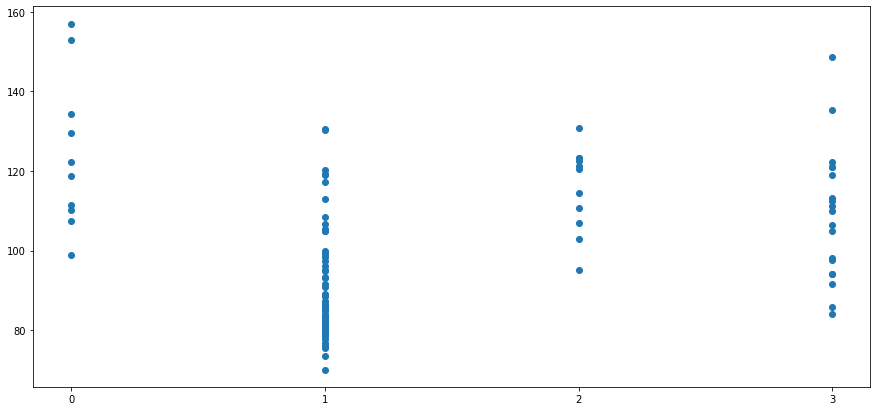

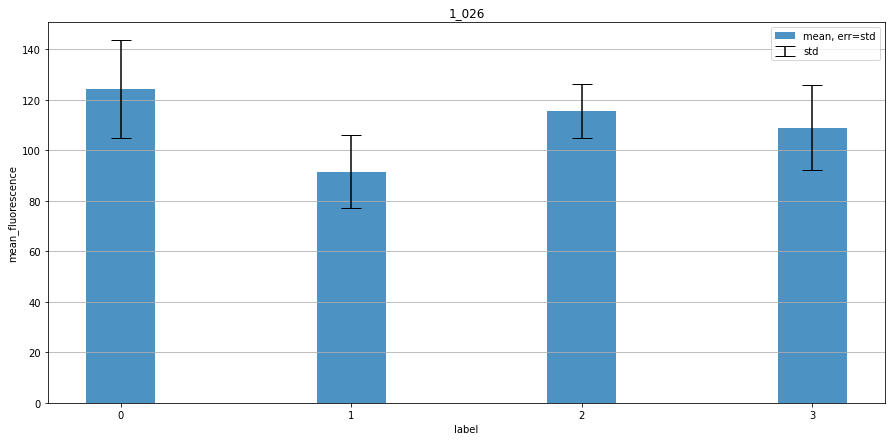

In [3]:
encodes = np.load('data/individual/' + video + '/encodes.npy')
print('encodes', encodes.shape)

tracks = np.genfromtxt('data/individual/' + video + '/trajectories.csv', delimiter=',', skip_header=True)
print('tracks', tracks.shape)
ids = np.unique(tracks[:, 0])
print('ids', len(ids))
frames = np.unique(tracks[:, 4])
print('frames', len(frames))
# id,x,y,fluorescence,frame

km = KMeans(n_clusters=4)
km.fit(encodes)
# print(km.labels_)
print('km.labels_', len(km.labels_))

tracks_info = pd.DataFrame(columns=['id', 'label', 'mean_fluorescence'])
tracks_info['id'] = ids
tracks_info['label'] = km.labels_
# print(tracks_info)
mean_fluorescence = []
for k, track_id in enumerate(ids):
    track = tracks[tracks[:, 0] == track_id]
    mean_fluorescence.append(np.nanmean(track[track[:, 3] != 0][:, 3]))
tracks_info['mean_fluorescence'] = mean_fluorescence
# print(tracks_info)
fig = plt.figure(figsize=(15, 7))
plt.scatter(tracks_info['label'], tracks_info['mean_fluorescence'])
plt.xticks([0, 1, 2, 3])
plt.show()

labels_groups = tracks_info.groupby('label')['mean_fluorescence'].describe()
# print(labels_groups)
width = 0.3
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
# ax.bar(labels_groups.index + width*(-2), labels_groups['min'], width, label='min')
ax.bar(labels_groups.index + width*(0), labels_groups['mean'], width, label='mean, err=std', alpha=0.8)
ax.errorbar(labels_groups.index, labels_groups['mean'], yerr = labels_groups['std'], label='std',
            fmt=' ', ecolor='k', capsize=10)
# ax.bar(labels_groups.index + width*(0), labels_groups['50%'], width, label='median')
# ax.bar(labels_groups.index + width*(1), labels_groups['max'], width, label='max')
ax.yaxis.grid(True)
plt.xticks([0, 1, 2, 3])
plt.legend()
plt.title(video)
ax.set_xlabel('label')
ax.set_ylabel('mean_fluorescence')
plt.show()
fig.savefig('data/individual/' + video + '/mean_fluorescence.png')

In [5]:
import seaborn as sns

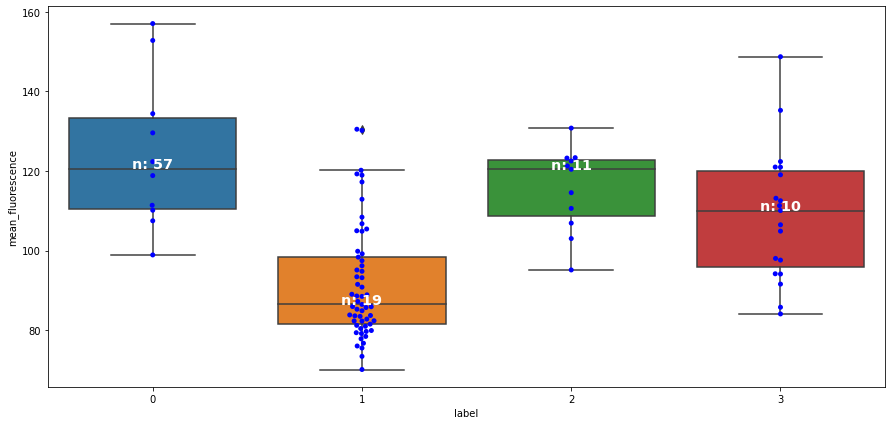

In [6]:
fig = plt.figure(figsize=(15, 7))
ax = sns.boxplot(x="label", y="mean_fluorescence", data=tracks_info)
medians = tracks_info.groupby(['label'])['mean_fluorescence'].median().values
nobs = tracks_info['label'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
# Add it to the plot
pos = range(len(nobs))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick] + 0.03, nobs[tick],
    horizontalalignment='center', size='x-large', color='w', weight='semibold')

ax = sns.swarmplot(x='label', y='mean_fluorescence', data=tracks_info, color="blue")
plt.show()

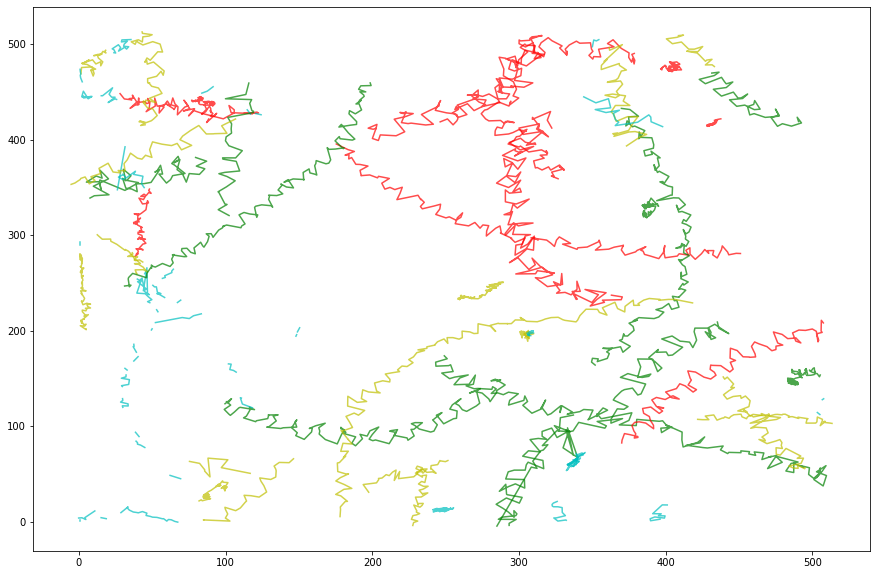

In [8]:
plt.figure(figsize=(15,10))
colors = ['r', 'c', 'g', 'y']
random_ids = np.random.choice(ids, size=97, replace=False)
for random_id in random_ids:
    label = tracks_info[tracks_info['id'] == random_id]['label'].to_numpy()[0]
    track = tracks[tracks[:, 0] == random_id]
    plt.plot(track[:, 1], track[:, 2], c=colors[label], alpha=0.7)
plt.show()

## Casificación en función de la motilidad

encodes shape: (97, 20)


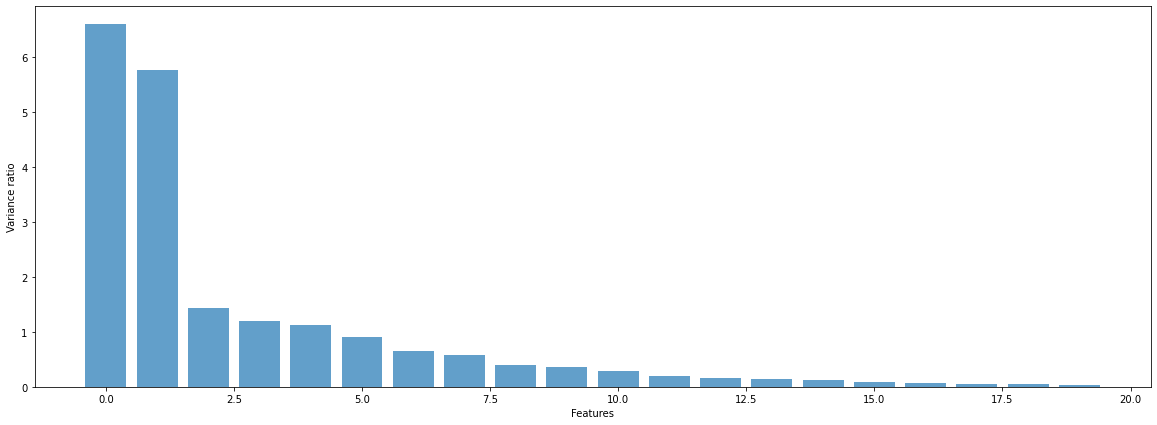

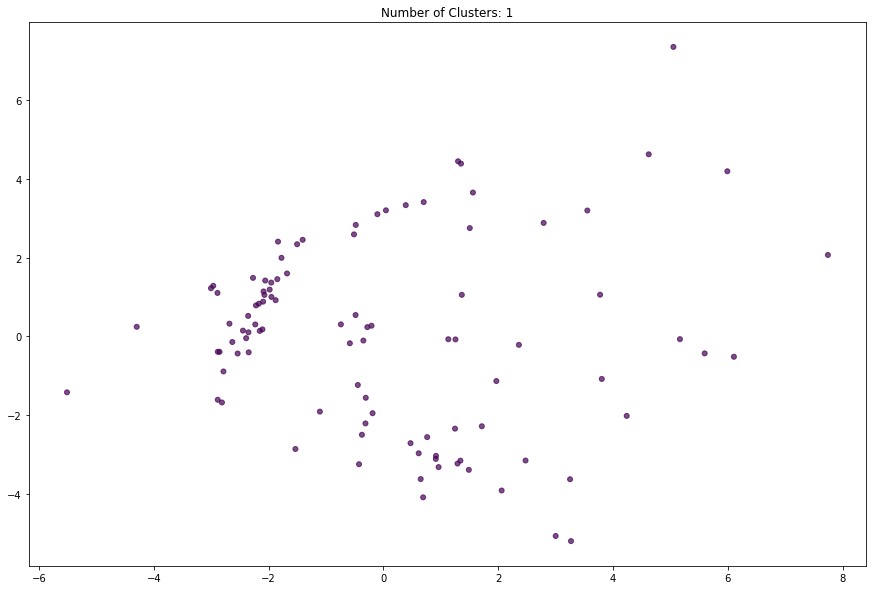

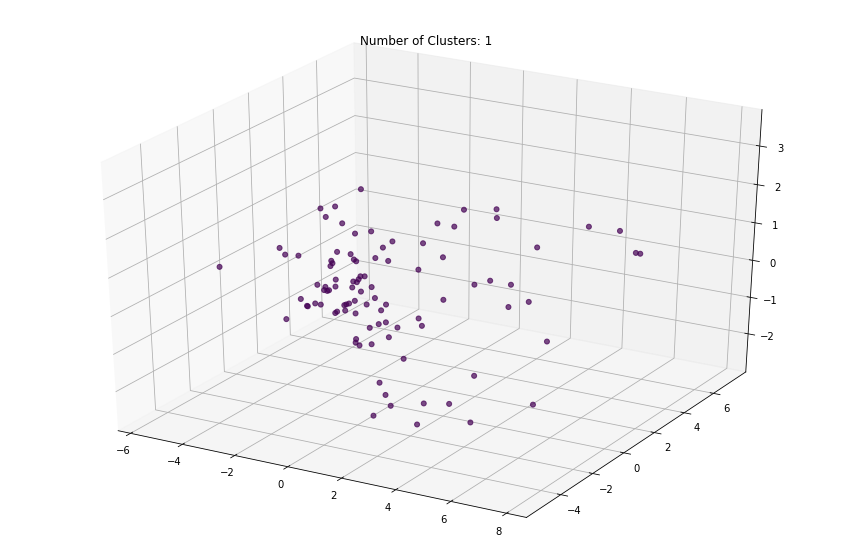

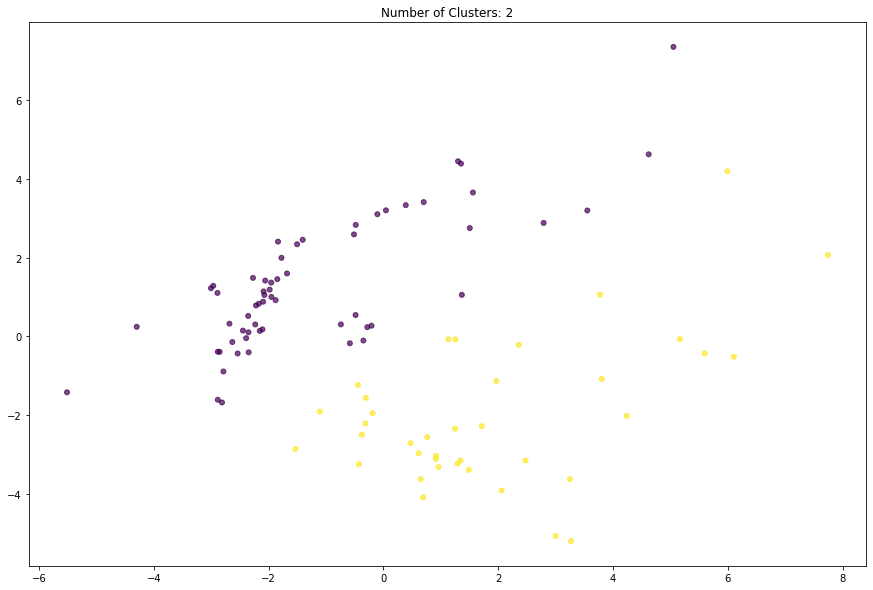

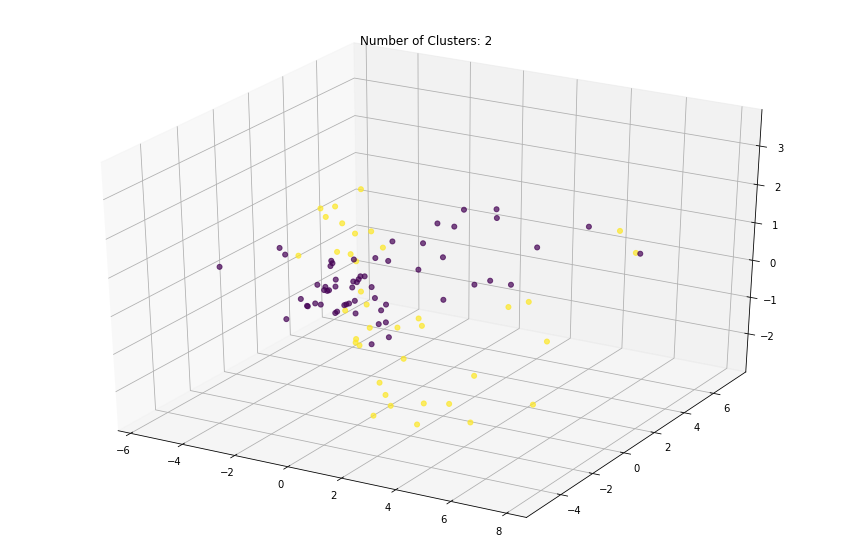

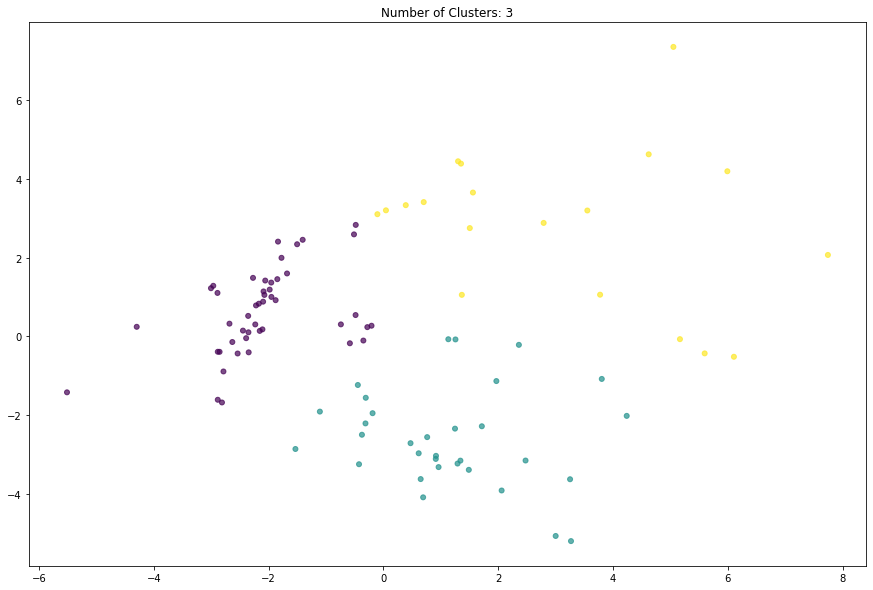

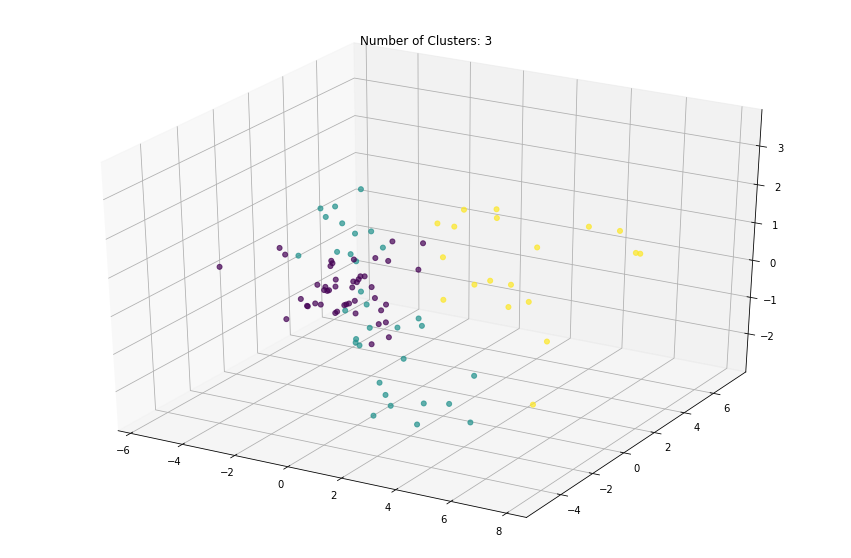

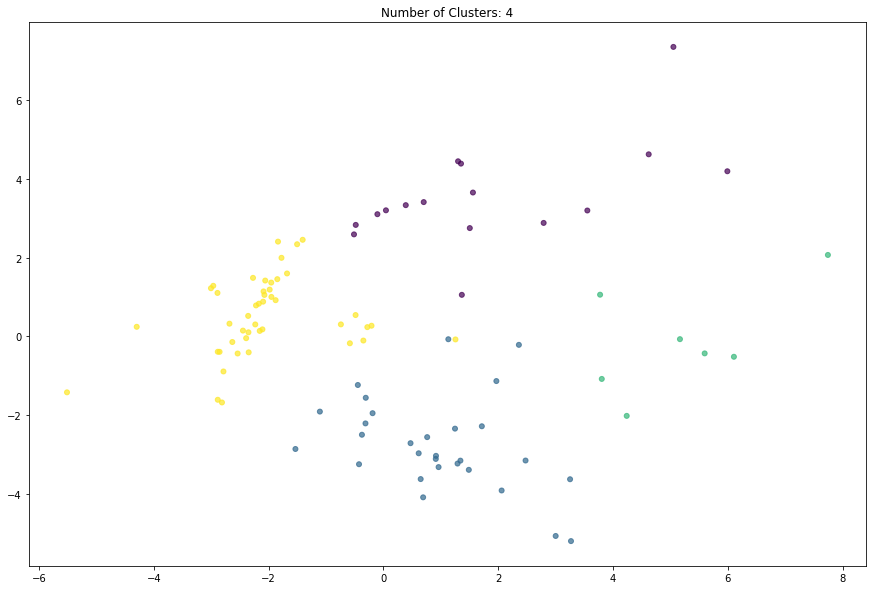

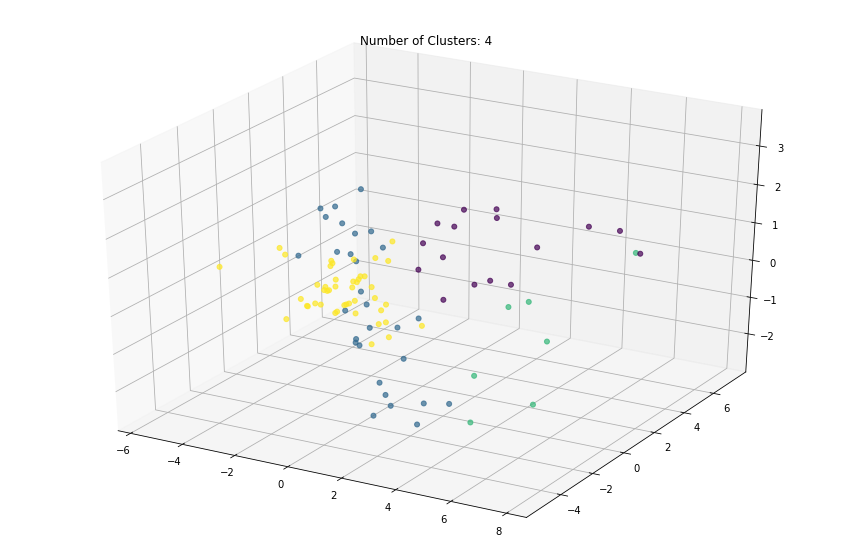

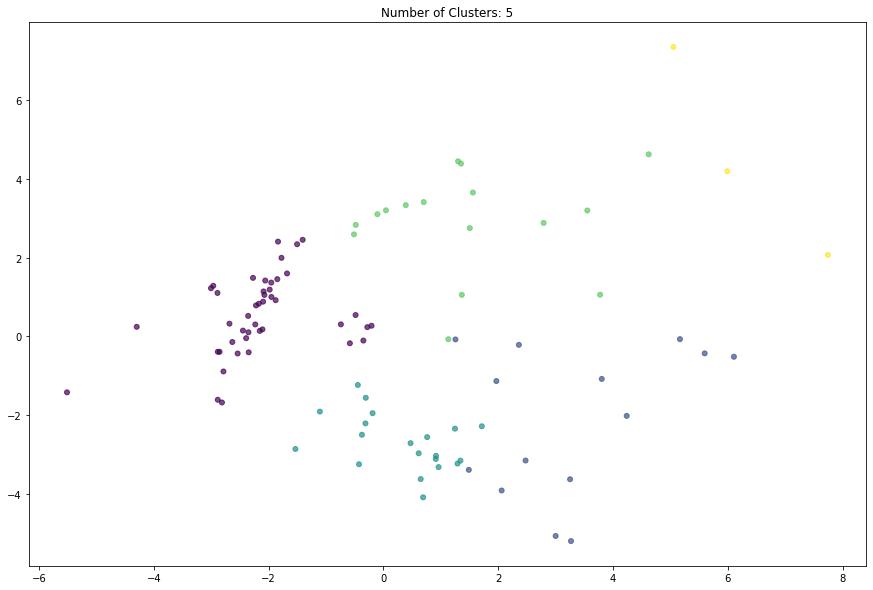

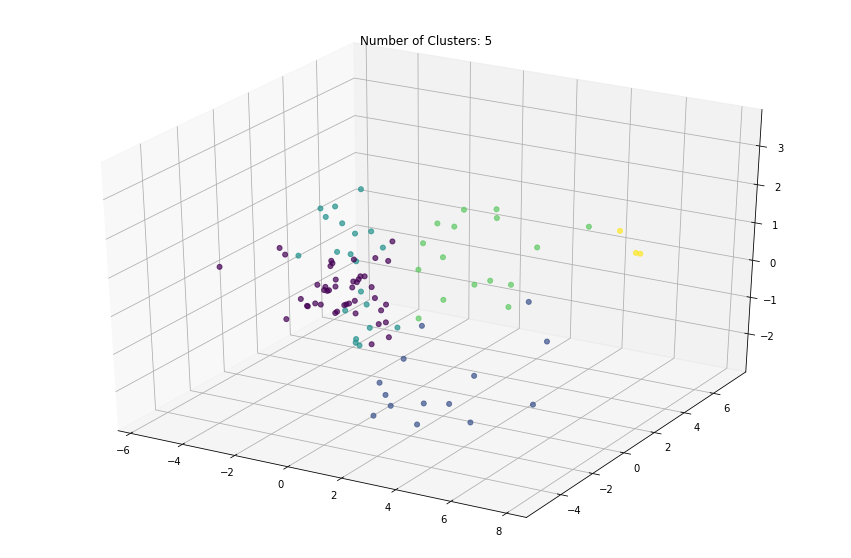

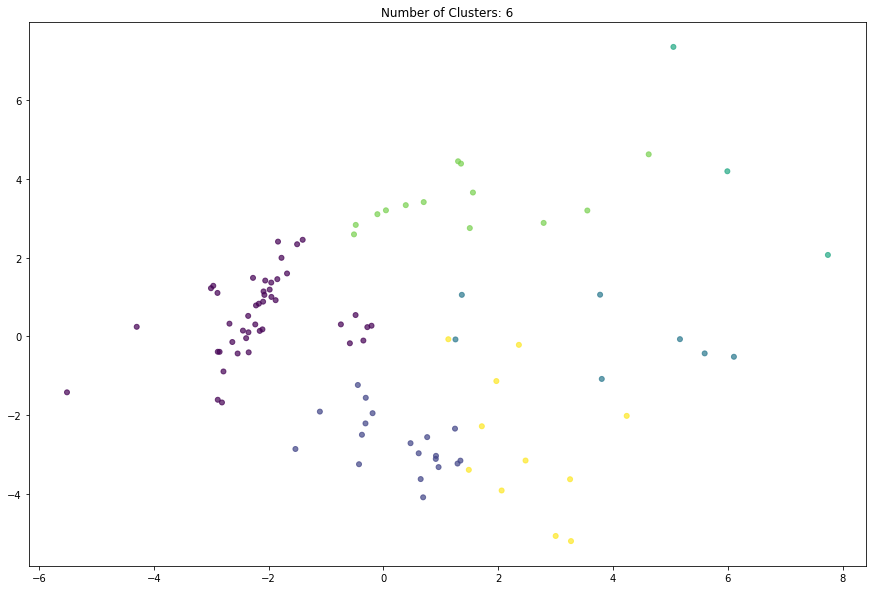

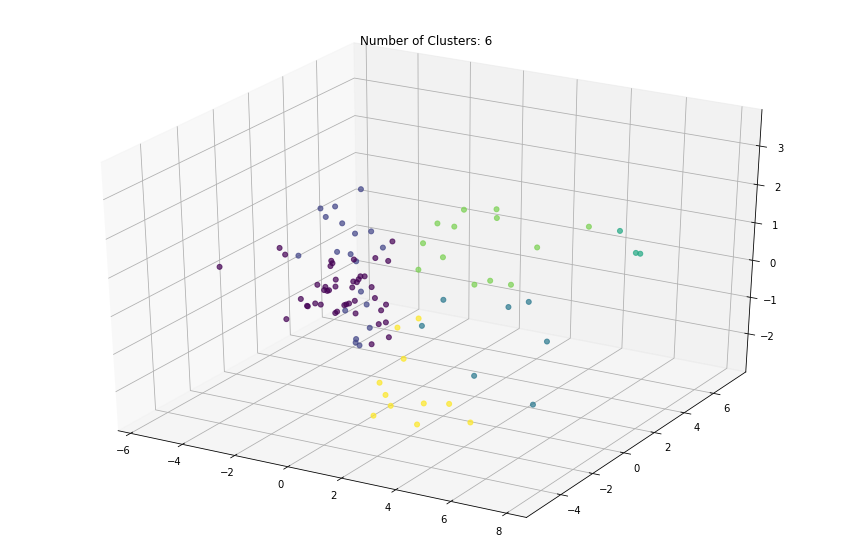

In [21]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
print('encodes shape:', encodes.shape)
# normalize
scaler = StandardScaler()
measures_scaled = scaler.fit_transform(encodes)
# features variance
pca = PCA()
measures_scaled = pca.fit_transform(measures_scaled)
pca_variance = pca.explained_variance_

plt.figure(figsize=(20, 7))
plt.bar(range(len(pca_variance)), pca_variance, alpha=0.7)
plt.ylabel('Variance ratio')
plt.xlabel('Features')
plt.show()

for i in range(1, 7):
    plt.figure(figsize=(15, 10))
    y_pred = KMeans(n_clusters=i).fit_predict(measures_scaled)
    plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")
    
plt.show();    

encodes size: (97, 20)
mean_fluorescence len: 97
encodes_fluo size (not nan): (97, 21)


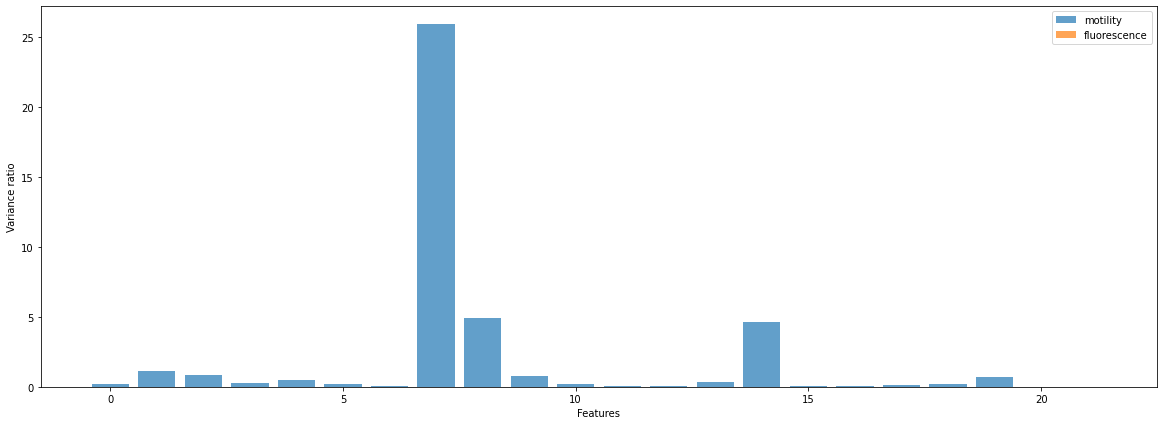

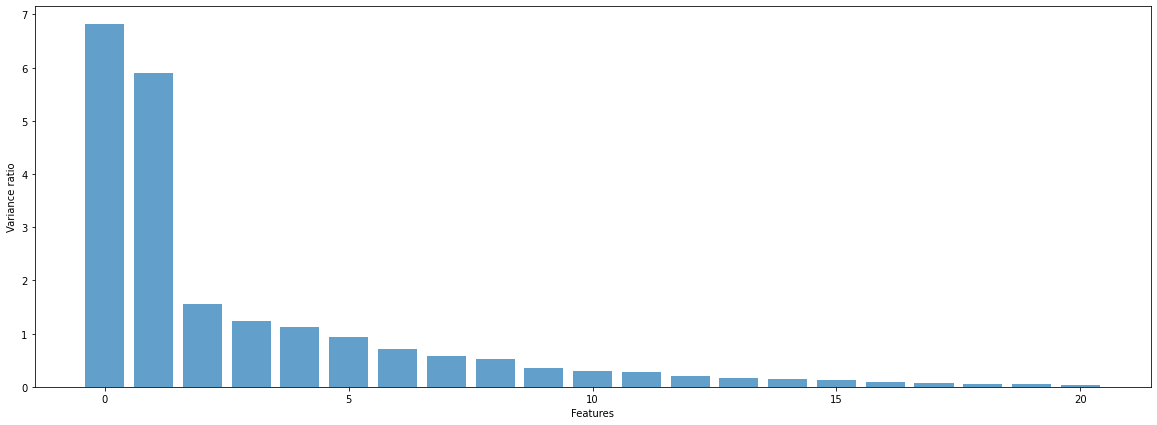

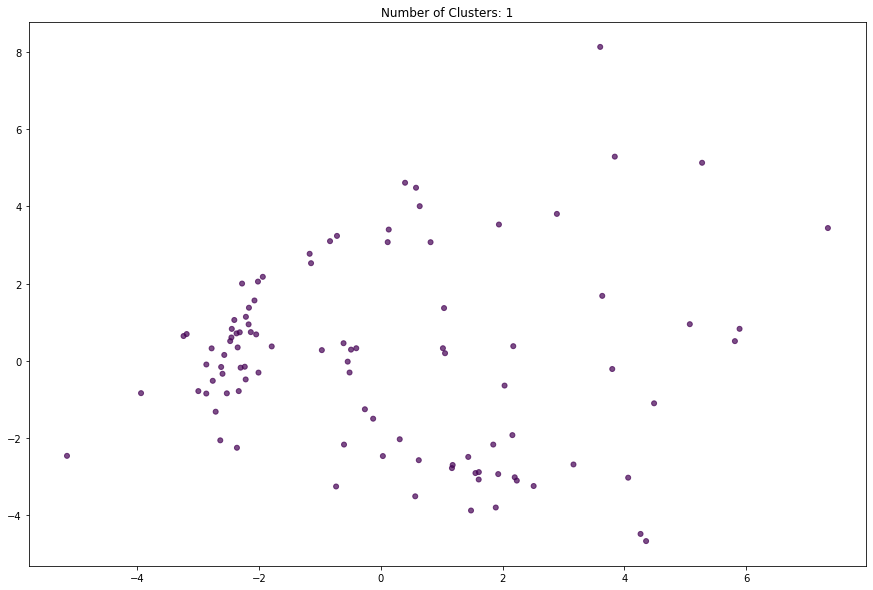

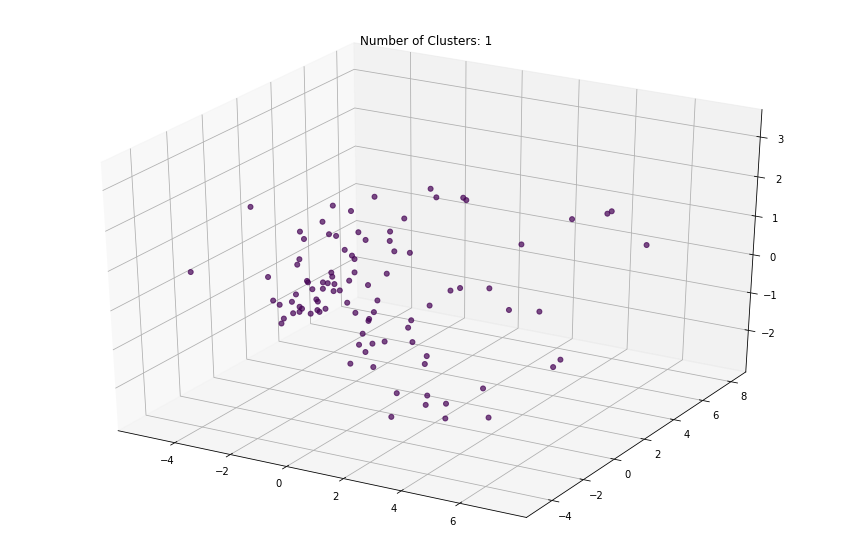

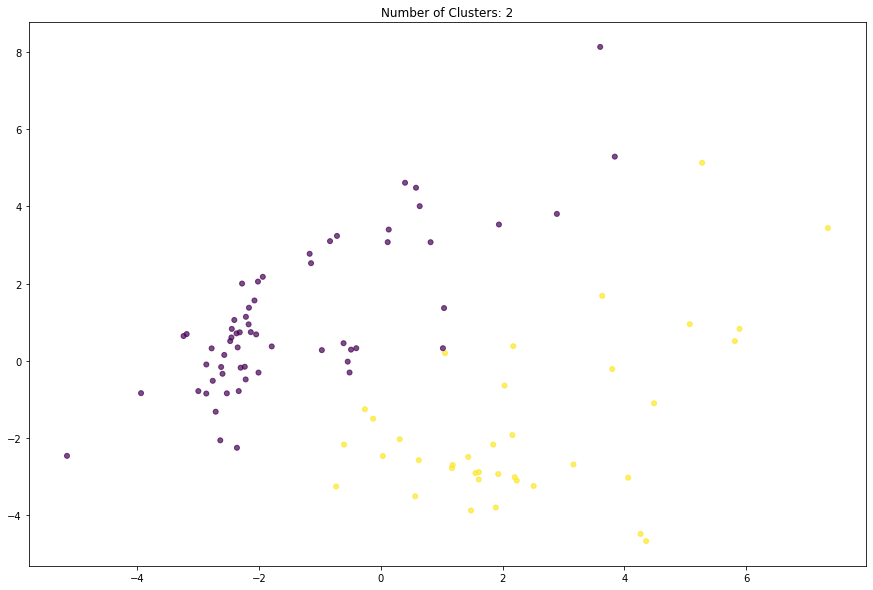

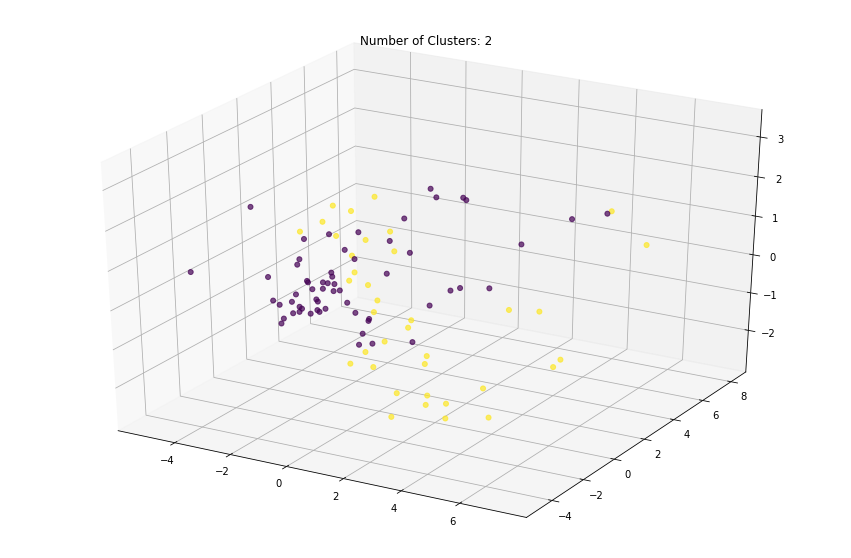

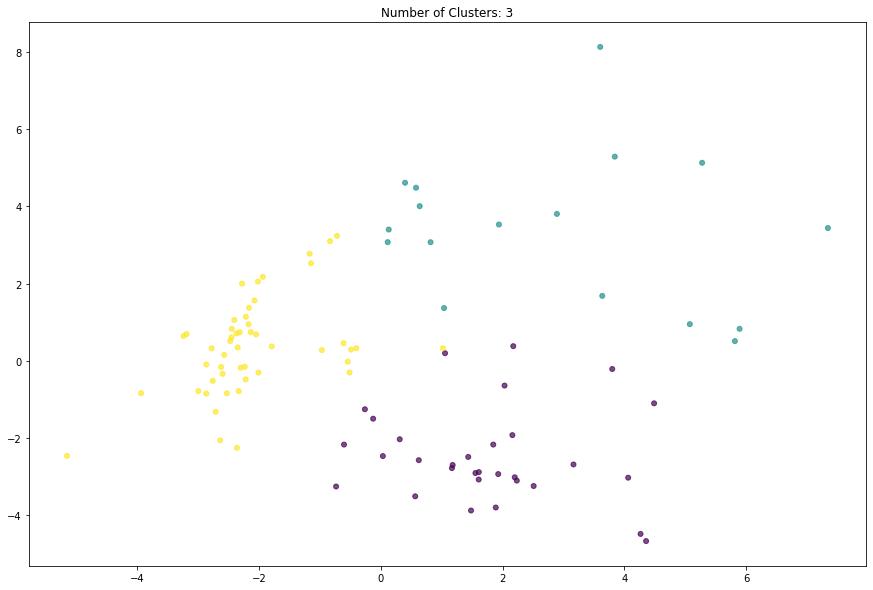

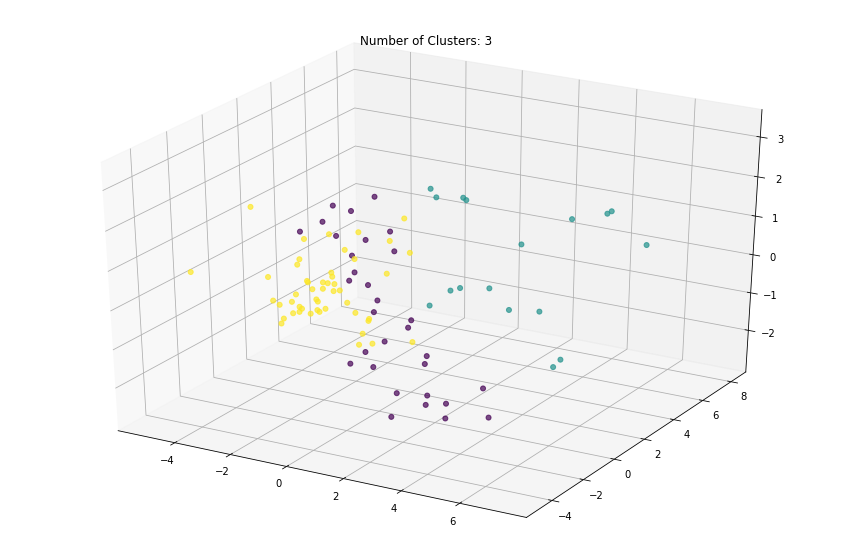

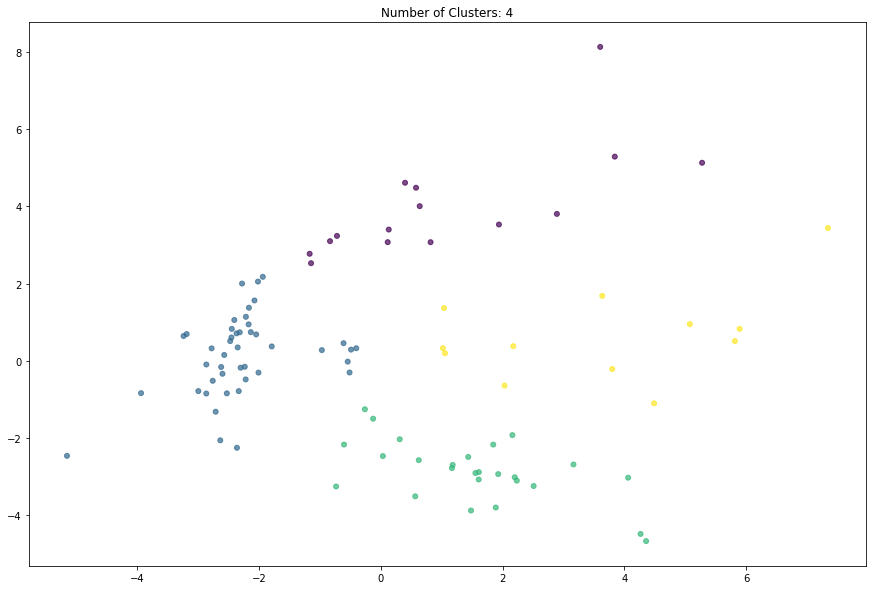

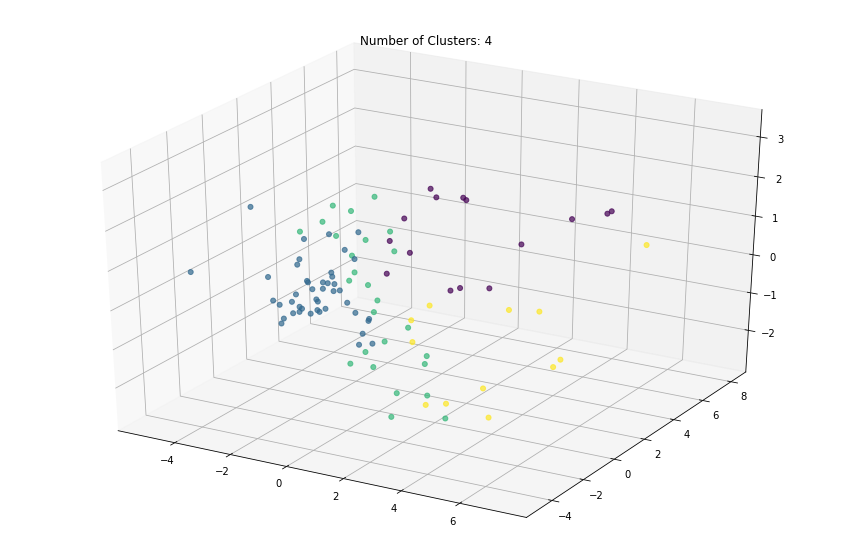

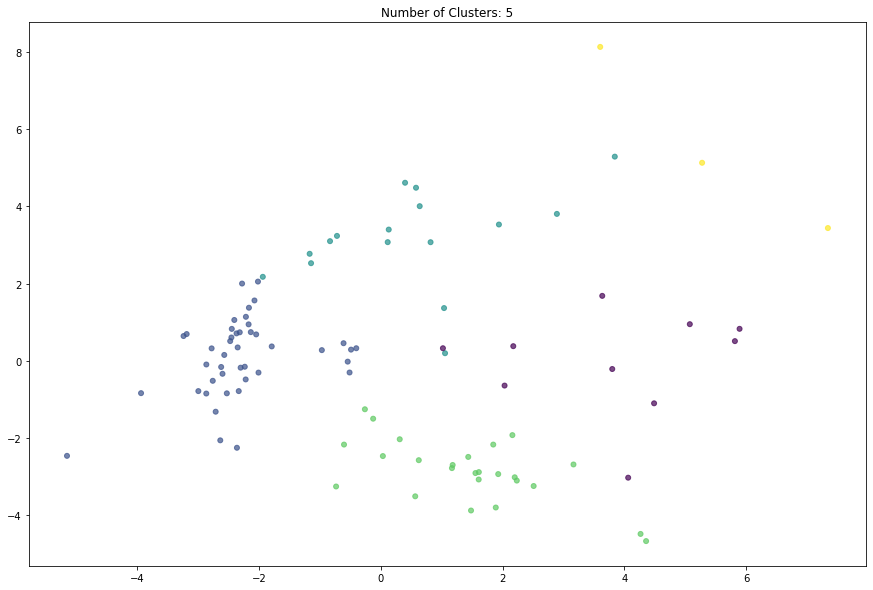

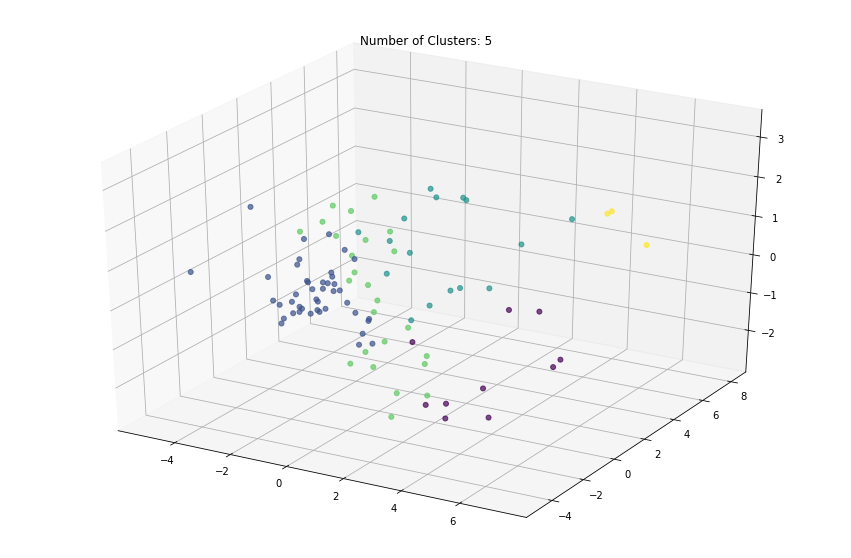

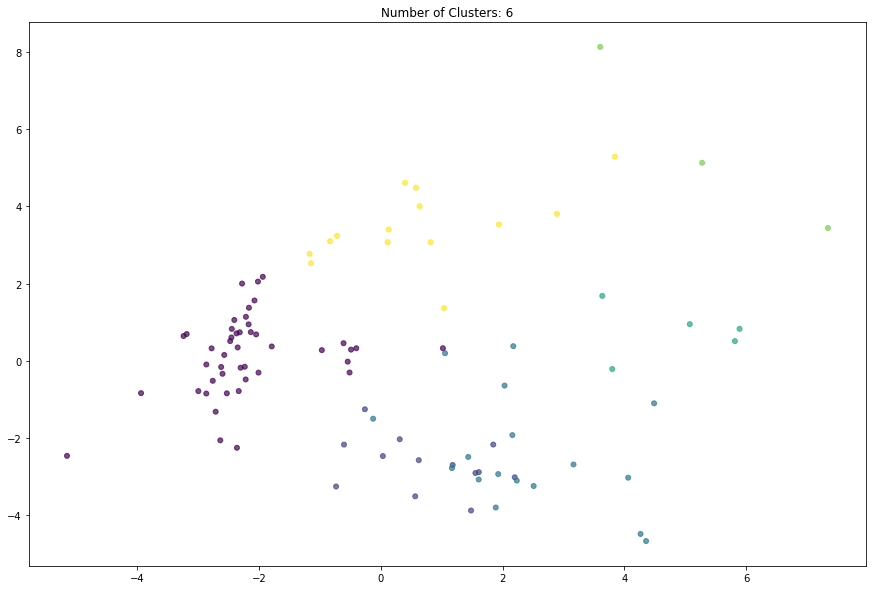

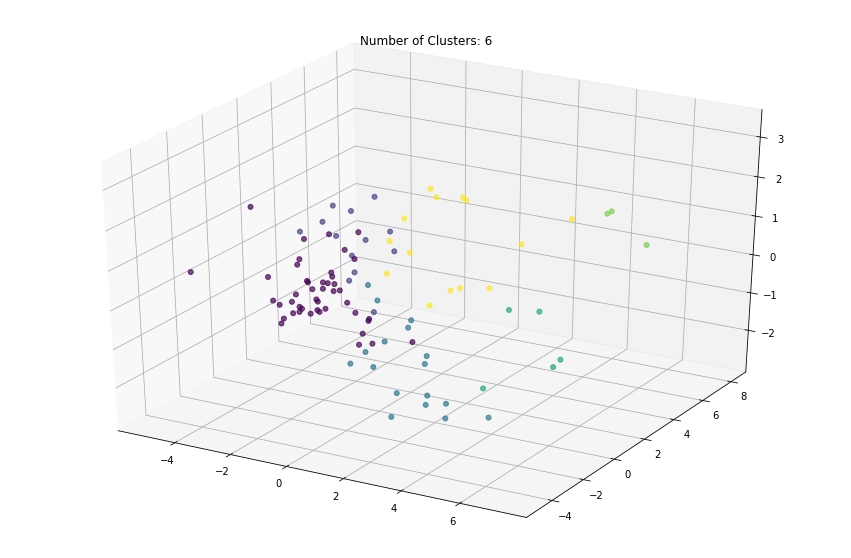

In [19]:
print('encodes size:', encodes.shape)
print('mean_fluorescence len:', len(mean_fluorescence))
# normalize
mean_fluorescence = np.array(mean_fluorescence)/255
encodes_fluo = np.concatenate((encodes, mean_fluorescence[:, np.newaxis]), axis=1)
encodes_fluo = encodes_fluo[~np.isnan(mean_fluorescence), :]
print('encodes_fluo size (not nan):', encodes_fluo.shape)

variance = np.var(encodes_fluo, axis=0)
plt.figure(figsize=(20, 7))
plt.bar(range(len(variance) - 1), variance[:-1], alpha=0.7, label='motility')
plt.bar(len(variance), variance[-1], alpha=0.7, label='fluorescence')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Features')
plt.show()


scaler = StandardScaler()
measures_scaled = scaler.fit_transform(encodes_fluo)
# features variance
pca = PCA()
measures_scaled = pca.fit_transform(measures_scaled)
pca_variance = pca.explained_variance_

plt.figure(figsize=(20, 7))
plt.bar(range(len(pca_variance)), pca_variance, alpha=0.7)
plt.ylabel('Variance ratio')
plt.xlabel('Features')
plt.show()

for i in range(1, 7):
    plt.figure(figsize=(15, 10))
    y_pred = KMeans(n_clusters=i).fit_predict(measures_scaled)
    plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=y_pred, s=25, alpha=0.7)
    plt.title(f"Number of Clusters: {i}")

plt.show();

## Who classification

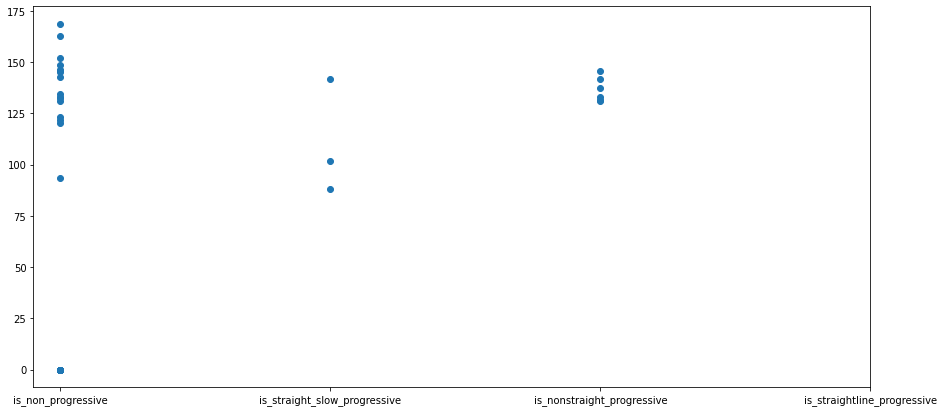

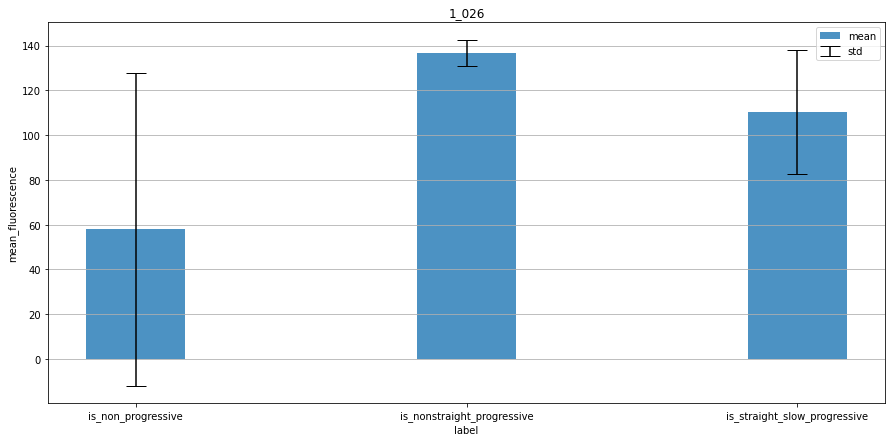

In [20]:
who_classification = pd.read_csv('data/individual/' + video + '/who_classification.csv', index_col=False)
who_classification.head()

fig = plt.figure(figsize=(15, 7))
plt.scatter(who_classification['motility_type'], who_classification['fluo'])
plt.xticks([0, 1, 2, 3])
plt.show()

motility_groups = who_classification.groupby('motility_type')['fluo'].describe()
width = 0.3
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
ax.bar(motility_groups.index, motility_groups['mean'], width, label='mean', alpha=0.8)
ax.errorbar(motility_groups.index, motility_groups['mean'], yerr = motility_groups['std'], label='std',
            fmt=' ', ecolor='k', capsize=10)
ax.yaxis.grid(True)
# plt.xticks([0, 1, 2, 3])
plt.legend()
plt.title(video)
ax.set_xlabel('label')
ax.set_ylabel('mean_fluorescence')
plt.show()

### Filtering fluo=0

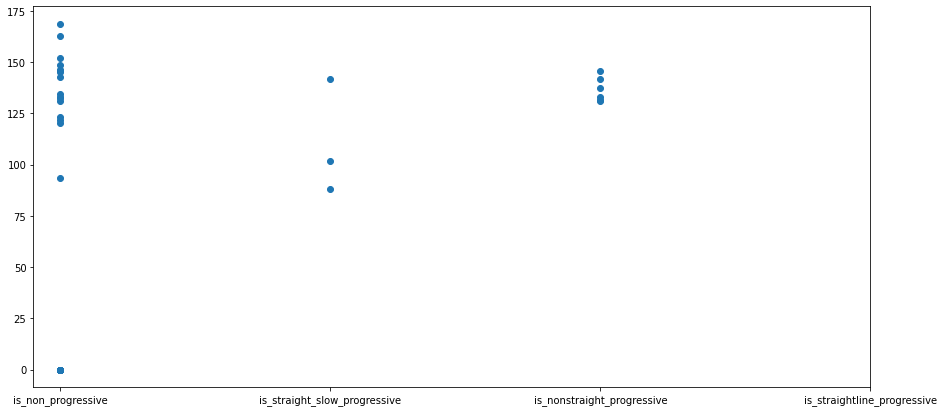

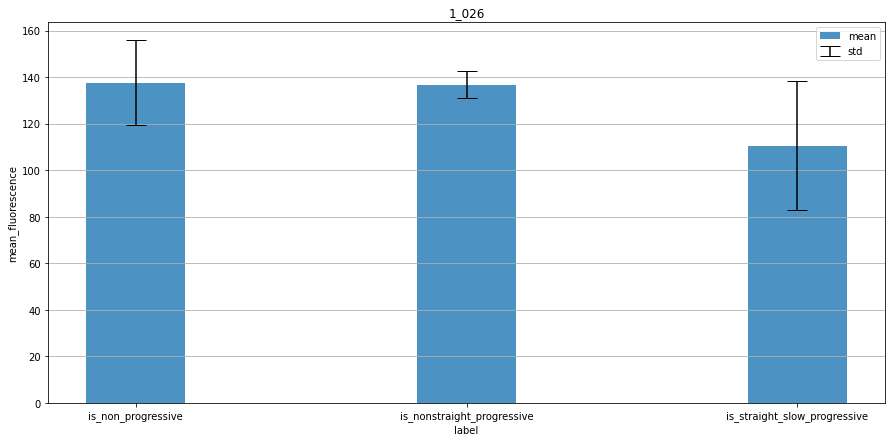

In [21]:
who_classification = pd.read_csv('data/individual/' + video + '/who_classification.csv')
who_classification.head()

fig = plt.figure(figsize=(15, 7))
plt.scatter(who_classification['motility_type'], who_classification['fluo'])
plt.xticks([0, 1, 2, 3])
plt.show()

who_classification_filtered = who_classification[who_classification['fluo'] > 0]
motility_groups = who_classification_filtered.groupby('motility_type')['fluo'].describe()
width = 0.3
fig = plt.figure(figsize=(15, 7))
ax = fig.gca()
ax.bar(motility_groups.index, motility_groups['mean'], width, label='mean', alpha=0.8)
ax.errorbar(motility_groups.index, motility_groups['mean'], yerr = motility_groups['std'], label='std',
            fmt=' ', ecolor='k', capsize=10)
ax.yaxis.grid(True)
# plt.xticks([0, 1, 2, 3])
plt.legend()
plt.title(video)
ax.set_xlabel('label')
ax.set_ylabel('mean_fluorescence')
plt.show()

## Who classification and trajectory encoding

['is_non_progressive', 'is_straight_slow_progressive', 'is_nonstraight_progressive', 'is_straightline_progressive']
97
len(who_labels_int) 97


Text(0.5, 0.92, 'Number of Clusters: 4')

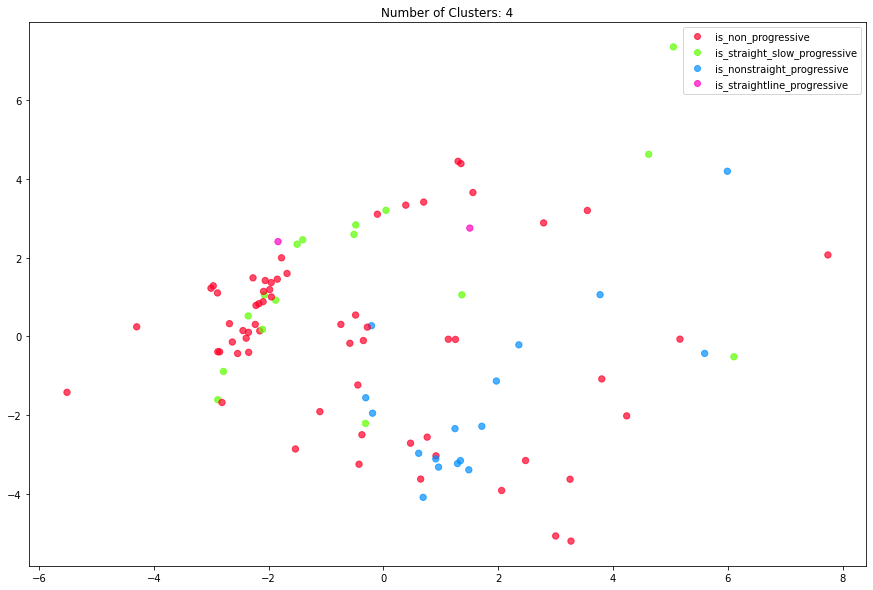

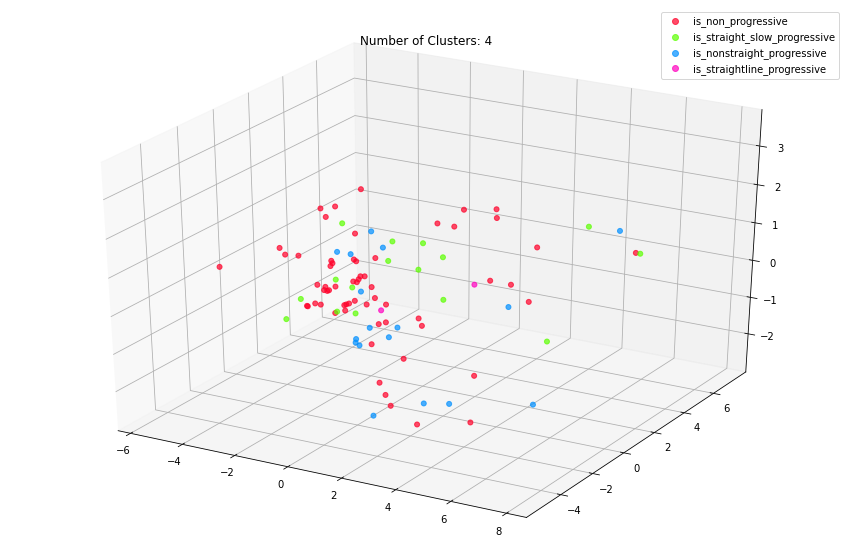

In [22]:
encodes = np.load('data/individual/' + video + '/encodes.npy')
# print(who_classification)
# print(tracks_info)
who_labels = list(who_classification['motility_type'].unique())
who_labels_int = [who_labels.index(label) for label in who_classification['motility_type']]
print(who_labels)
# print(who_labels_int)
print(len(who_classification['track_id'].unique()))
print('len(who_labels_int)', len(who_labels_int))
# normalize
scaler = StandardScaler()
measures_scaled = scaler.fit_transform(encodes)
# features variance
pca = PCA()
measures_scaled = pca.fit_transform(measures_scaled)
pca_variance = pca.explained_variance_

plt.figure(figsize=(15, 10))
scatter = plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=who_labels_int, cmap='gist_rainbow', s=40, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels)
plt.title(f"Number of Clusters: 4")

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2],
                     c=who_labels_int, cmap='gist_rainbow', s=25, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels)
plt.title(f"Number of Clusters: 4")


Text(0.5, 0.92, 'Number of Clusters: 4')

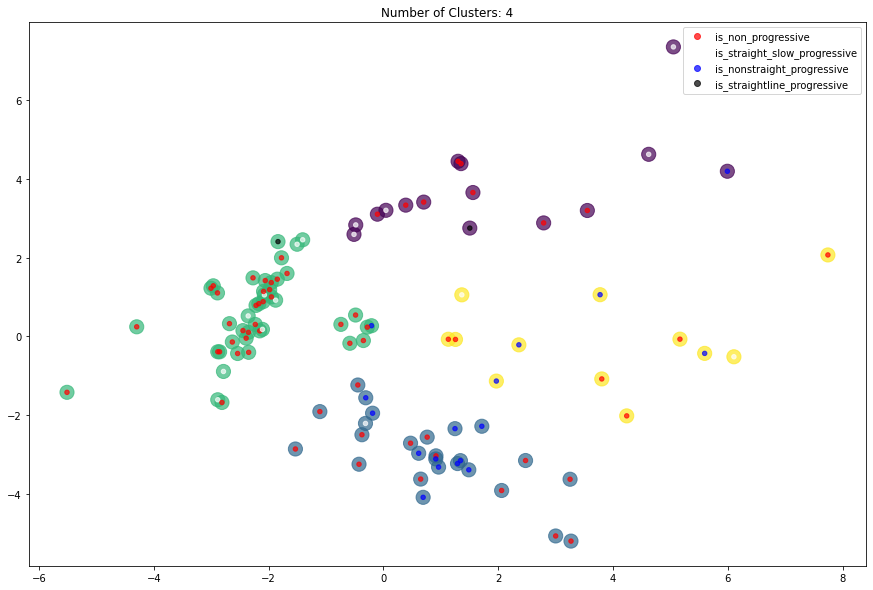

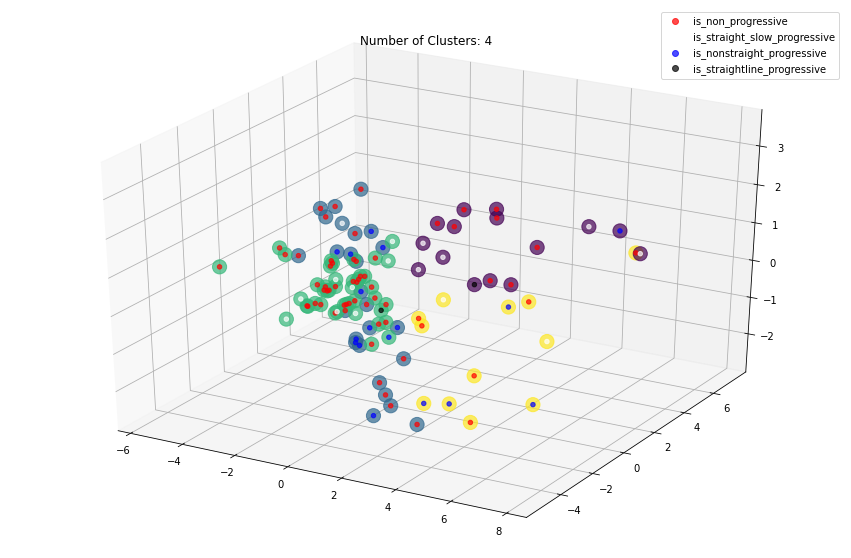

In [23]:
y_pred = KMeans(n_clusters=4).fit_predict(measures_scaled)

plt.figure(figsize=(15, 10))
plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=y_pred, s=200, alpha=0.7)
scatter = plt.scatter(measures_scaled[:, 0], measures_scaled[:, 1], c=who_labels_int, s=20, alpha=0.7, cmap='flag')
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels)
plt.title(f"Number of Clusters: 4")

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=y_pred, s=200, alpha=0.7)
scatter = ax.scatter(measures_scaled[:, 0], measures_scaled[:, 1], measures_scaled[:, 2], c=who_labels_int,
                     cmap='flag', s=20, alpha=0.7)
plt.legend(handles=scatter.legend_elements()[0], labels=who_labels)
plt.title(f"Number of Clusters: 4")


Text(0.5, 0, 'ALH')

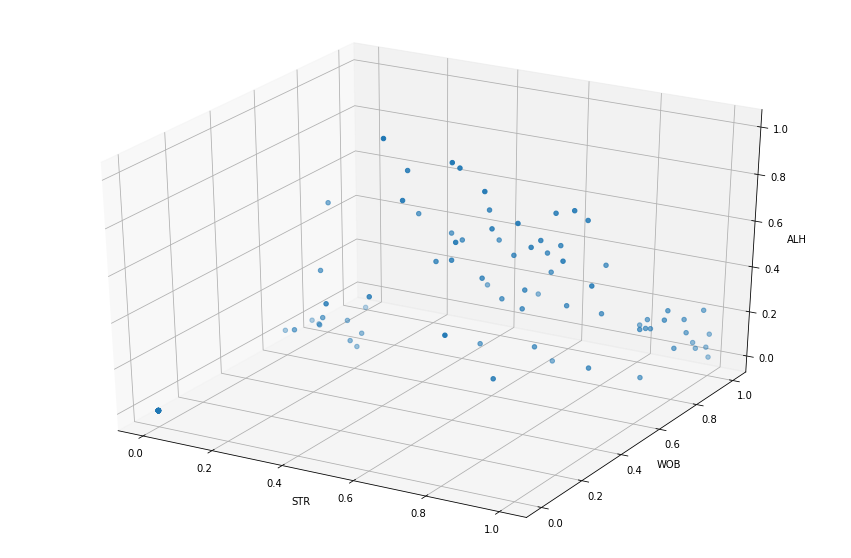

In [24]:
who_features = who_classification[['alh_mean', 'wob', 'str']]

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(who_features['str']/who_features['str'].max(), who_features['wob']/who_features['wob'].max()
           , who_features['alh_mean']/who_features['alh_mean'].max())
ax.set_xlabel('STR')
ax.set_ylabel('WOB')
ax.set_zlabel('ALH')
# plt.show()

    Unnamed: 0  track_id        vcl        vsl   vap_mean     vap_std  \
0            0         1   7.780074   0.165793   4.125651  159.178667   
1            1         2  15.723208  11.956990  13.827718    8.499461   
2            2         3   8.579601   1.060489   4.440469   82.358557   
3            3         4   0.000000   0.000000   0.000000    0.000000   
4            4         5  32.838847  12.027582  20.882229   44.127483   
..         ...       ...        ...        ...        ...         ...   
92          92       151  12.044268   0.998690   5.818911   18.311251   
93          93       153  17.004246  13.914700  14.071286   18.558231   
94          94       155   0.000000   0.000000   0.000000    0.000000   
95          95       156  29.303704  23.910008  25.083329   18.596297   
96          96       158   0.000000   0.000000   0.000000    0.000000   

    alh_mean   alh_std       lin       wob       str   bcf_mean   bcf_std  \
0   0.076396  0.137082  0.021310  0.530284  0.

Text(0, 0.5, 'fluo')

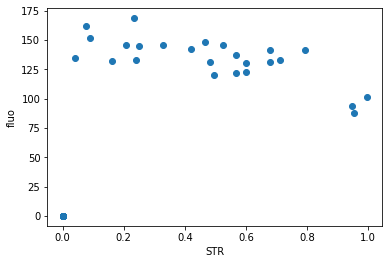

In [13]:
print(who_classification)
plt.scatter(who_classification['str'], who_classification['fluo'])
plt.xlabel('STR')
plt.ylabel('fluo')
# plt.show()


### Los valores de los encodes varían cada vez que se corre la generación de encodes.

In [14]:
encodes = np.load('data/test/test_encodes.npy')
encodes_1 = np.load('data/test/test_encodes_1.npy')
encodes_2 = np.load('data/test/test_encodes_2.npy')

# print('encodes_old', encodes_old)
# print('encodes', encodes)
print('\n')

print('encodes - encodes_1:   ', np.linalg.norm(encodes - encodes_1))
print('encodes - encodes_2:   ', np.linalg.norm(encodes - encodes_2))
print('encodes_1 - encodes_2: ', np.linalg.norm(encodes_1 - encodes_2))
print('\n')

print('encodes[0, :] - encodes[0, :]:     ', np.linalg.norm(encodes[0, :] - encodes[0, :]))
print('encodes_1[0, :] - encodes_1[0, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_1[0, :]))
print('encodes_2[0, :] - encodes_2[0, :]: ', np.linalg.norm(encodes_2[0, :] - encodes_2[0, :]))

print('encodes[0, :] - encodes_1[0, :]:   ', np.linalg.norm(encodes[0, :] - encodes_1[0, :]))
print('encodes[0, :] - encodes_2[0, :]:   ', np.linalg.norm(encodes[0, :] - encodes_2[0, :]))
print('encodes_1[0, :] - encodes_2[0, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_2[0, :]))
print('\n')

print('track 0 - track 1')
print('encodes[0, :] - encodes[1, :]:     ', np.linalg.norm(encodes[0, :] - encodes[1, :]))
print('encodes_1[0, :] - encodes_1[1, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_1[1, :]))
print('encodes_2[0, :] - encodes_2[1, :]: ', np.linalg.norm(encodes_2[0, :] - encodes_2[1, :]))

print('encodes[0, :] - encodes_1[1, :]:   ', np.linalg.norm(encodes[0, :] - encodes_1[1, :]))
print('encodes[0, :] - encodes_2[1, :]:   ', np.linalg.norm(encodes[0, :] - encodes_2[1, :]))
print('encodes_1[0, :] - encodes_2[1, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_2[1, :]))
print('\n')

print('track 0 - track 2')
print('encodes[0, :] - encodes[2, :]:     ', np.linalg.norm(encodes[0, :] - encodes[2, :]))
print('encodes_1[0, :] - encodes_1[2, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_1[2, :]))
print('encodes_2[0, :] - encodes_2[2, :]: ', np.linalg.norm(encodes_2[0, :] - encodes_2[2, :]))

print('encodes[0, :] - encodes_1[2, :]:   ', np.linalg.norm(encodes[0, :] - encodes_1[2, :]))
print('encodes[0, :] - encodes_2[2, :]:   ', np.linalg.norm(encodes[0, :] - encodes_2[2, :]))
print('encodes_1[0, :] - encodes_2[2, :]: ', np.linalg.norm(encodes_1[0, :] - encodes_2[2, :]))
print('\n')

print('track 1 - track 2')
print('encodes[1, :] - encodes[2, :]:     ', np.linalg.norm(encodes[1, :] - encodes[2, :]))
print('encodes_1[1, :] - encodes_1[2, :]: ', np.linalg.norm(encodes_1[1, :] - encodes_1[2, :]))
print('encodes_2[1, :] - encodes_2[2, :]: ', np.linalg.norm(encodes_2[1, :] - encodes_2[2, :]))

print('encodes[1, :] - encodes_1[2, :]:   ', np.linalg.norm(encodes[1, :] - encodes_1[2, :]))
print('encodes[1, :] - encodes_2[2, :]:   ', np.linalg.norm(encodes[1, :] - encodes_2[2, :]))
print('encodes_1[1, :] - encodes_2[2, :]: ', np.linalg.norm(encodes_1[1, :] - encodes_2[2, :]))
print('\n')



encodes - encodes_1:    7.211552
encodes - encodes_2:    7.0640173
encodes_1 - encodes_2:  6.831568


encodes[0, :] - encodes[0, :]:      0.0
encodes_1[0, :] - encodes_1[0, :]:  0.0
encodes_2[0, :] - encodes_2[0, :]:  0.0
encodes[0, :] - encodes_1[0, :]:    1.9486469
encodes[0, :] - encodes_2[0, :]:    1.8177702
encodes_1[0, :] - encodes_2[0, :]:  1.7233871


track 0 - track 1
encodes[0, :] - encodes[1, :]:      0.97254306
encodes_1[0, :] - encodes_1[1, :]:  0.9192217
encodes_2[0, :] - encodes_2[1, :]:  0.92799354
encodes[0, :] - encodes_1[1, :]:    2.1785927
encodes[0, :] - encodes_2[1, :]:    2.1070974
encodes_1[0, :] - encodes_2[1, :]:  2.0207903


track 0 - track 2
encodes[0, :] - encodes[2, :]:      0.8776459
encodes_1[0, :] - encodes_1[2, :]:  0.922174
encodes_2[0, :] - encodes_2[2, :]:  0.87832665
encodes[0, :] - encodes_1[2, :]:    2.6026645
encodes[0, :] - encodes_2[2, :]:    2.3808975
encodes_1[0, :] - encodes_2[2, :]:  2.274453


track 1 - track 2
encodes[1, :] - encodes[2